In [1]:
# !python -c "import torch; print(torch.__version__)"
# !nvcc --version
# !python -c "import torch; print(torch.version.cuda)"

!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_scatter-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-scatter 2.0.4
    Uninstalling torch-scatter-2.0.4:
      Successfully uninstalled torch-scatter-2.0.4
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_sparse-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-sparse 0.6.2
    Uninstalling torch-sparse-0.6.2:
      Successfully uninstalled torch-sparse-0.6.2
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
  Using cached https://pytorch-geometric.com/whl/torch-1.5.0/torch_cluster-latest%2Bcu101-cp36-cp36m-linux_x86_64.whl
  Found existing installation: torch-cluster 1.5.4
    Uninstalling torch-cluster-1.5.4:
      Successfully uninstalled torch-cluster-1.5.4
Looking in links: https

In [0]:
import os.path as osp
import torch
import random 
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import SVG
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from torch_geometric.nn import GraphConv, TopKPooling, GATConv, GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

%matplotlib inline

In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_24 = np.load('/content/drive/My Drive/imputed-normed-ep_1_24.npz', allow_pickle=True)

In [0]:
features_sequence = data_24['ep_tdata'].astype(np.float32) # 12 time series features
features_static = data_24['adm_features_all'].astype(np.float32) # 5 non-ts features,the unit of age: day
labels = data_24["adm_labels_all"][:, 2].astype(np.float32) # 2-day mortality
#labels = data_24["adm_labels_all"][:, 1].astype(np.float32) # 1-day mortality
#labels = data_24["adm_labels_all"][:, 0].astype(np.float32) # in-hospital mortality

#np.max(features_static)

In [0]:
trans = [0]*features_sequence.shape[0]
for i in range(features_sequence.shape[0]):
    trans[i] = features_sequence[i].T
trans= np.array(trans)

In [8]:
one_tenth_length = int(len(trans) * 0.1)
train_dataset_seq = trans[:one_tenth_length * 6]
val_dataset_seq = trans[one_tenth_length*6:one_tenth_length * 8]
test_dataset_seq = trans[one_tenth_length*8:]
#len(train_dataset_seq), len(val_dataset_seq), len(test_dataset_seq)

train_dataset_stat = features_static[:one_tenth_length * 6]
val_dataset_stat = features_static[one_tenth_length*6:one_tenth_length * 8]
test_dataset_stat = features_static[one_tenth_length*8:]
#len(train_dataset_stat), len(val_dataset_stat), len(test_dataset_stat)

train_dataset_label = labels[:one_tenth_length * 6]
val_dataset_label = labels[one_tenth_length*6:one_tenth_length * 8]
test_dataset_label = labels[one_tenth_length*8:]
len(train_dataset_label), len(val_dataset_label), len(test_dataset_label)

(21654, 7218, 7221)

In [9]:
# upsampling
x_seq_up = []
x_static_up = []
y_up = []
for i in range(train_dataset_seq.shape[0]):
    count = 0
    if train_dataset_label[i] == 1:
        while count < 50:        #50 for 1-day, 5 for in-hosp
            x_seq_up.append(train_dataset_seq[i])
            x_static_up.append(train_dataset_stat[i])
            y_up.append(train_dataset_label[i])
            count += 1

a = np.concatenate((train_dataset_seq, x_seq_up))
b = np.concatenate((train_dataset_stat, x_static_up))
c = np.concatenate((train_dataset_label, y_up))


index = list(range(len(c)))
np.random.shuffle(index)

features_sequence = []
features_static = []
labels = []

for i in index:
    features_sequence.append(a[i])
    features_static.append(b[i])
    labels.append(c[i])

features_sequence  = np.array(features_sequence)
features_static = np.array(features_static)
labels = np.array(labels)
labels.shape

(40854,)

In [0]:
def impute_mean(source_data, input_data):
    '''
    Takes the source data, and uses it to determine means for all
    features; it then applies them to the input data.
    
    inputs:
    source_data: a tensor to provide means
    input_data: the data to fill in NA for
    
    output:
    output_data: data with nans imputed for each feature
    
    '''
    
    output_data = input_data.copy()
    
    for feature in range(source_data.shape[1]):
        feature_mean = np.nanmean(source_data[:, feature, :][np.where(source_data[:, feature, :] != 0)])
        ind_output_data = np.where(np.isnan(output_data[:, feature, :]))
        output_data[:, feature, :][ind_output_data] =  feature_mean
    return output_data

In [0]:
x_seq_train_original = features_sequence.copy()
tr_features_sequence = impute_mean(x_seq_train_original, features_sequence)

tes_features_sequence = impute_mean(x_seq_train_original, test_dataset_seq)

val_features_sequence = impute_mean(x_seq_train_original, val_dataset_seq)
#np.isnull(features_sequence)

In [12]:
from sklearn.preprocessing import normalize
features_static = normalize(features_static)
val_dataset_stat = normalize(val_dataset_stat)
test_dataset_stat = normalize(test_dataset_stat)

x=torch.from_numpy(tr_features_sequence).view(tr_features_sequence.shape[0],-1)
y=torch.from_numpy(features_static)
#print(x.shape,y.shape)
train_features=torch.cat((x, y), 1)

val_features=torch.cat((torch.from_numpy(val_dataset_seq).view(val_dataset_seq.shape[0],-1), torch.from_numpy(val_dataset_stat)),1)
test_features=torch.cat((torch.from_numpy(test_dataset_seq).view(test_dataset_seq.shape[0],-1), torch.from_numpy(test_dataset_stat)),1)

print(train_features.shape, val_features.shape, test_features.shape)

torch.Size([40854, 293]) torch.Size([7218, 293]) torch.Size([7221, 293])


In [13]:
EHRdata_train = []
EHRdata_test = []
EHRdata_val = []


edges=[]    # fully connected graph between all features

for i in range(293):
  for j in range(293):
    if(i!=j):
      t=(i,j)
      t_=(j,i)
      if t not in edges and t_ not in edges:
        edges.append(t)
        edges.append(t_)
x=[]
y=[]
for i in edges:
  x.append(i[0])
  y.append(i[1])
w=[]
w.append(x)
w.append(y)
w=np.asarray(w)
edges_index = torch.tensor([w[0],w[1]], dtype=torch.long)
print(edges_index.shape)

for x,y in zip(train_features,labels):
  node_features = torch.FloatTensor(x).unsqueeze(1)
  y = torch.FloatTensor([y])
  data = Data(x=node_features, edge_index=edges_index, y=y)
  EHRdata_train.append(data)

for x,y in zip(val_features,val_dataset_label):
  node_features = torch.FloatTensor(x).unsqueeze(1)
  y = torch.FloatTensor([y])
  data = Data(x=node_features, edge_index=edges_index, y=y)
  EHRdata_val.append(data)

for x,y in zip(test_features,test_dataset_label):
  node_features = torch.FloatTensor(x).unsqueeze(1)
  y = torch.FloatTensor([y])
  data = Data(x=node_features, edge_index=edges_index, y=y)
  EHRdata_test.append(data)

#EHR_loader = DataLoader(EHRdata, batch_size=32)
#random.shuffle(EHRdata)

torch.Size([2, 85556])


In [0]:
batch_size= 1
train_loader = DataLoader(EHRdata_train, batch_size=batch_size)
val_loader = DataLoader(EHRdata_val, batch_size=batch_size)
test_loader = DataLoader(EHRdata_test, batch_size=batch_size)

In [0]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = GraphConv(293*batch_size, 256)
        #self.pool1 = TopKPooling(256, ratio=0.8)
        self.conv2 = GraphConv(256, 256)
        #self.conv3 = GraphConv(256, 128)

        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #print('X first: ', x.shape, batch.shape)
        #x = torch.flatten(x)
        x = x.T
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.lin1(x))
        #print('X : ', x.shape)
        x = F.dropout(x, p=0.5, training=self.training)
        #print('X : ', x.shape)
        x = F.relu(self.lin2(x))
        #print('X : ', x.shape)
        x =F.sigmoid(self.lin3(x))
        #print('X last : ', x.shape)

        return x

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model

Net(
  (conv1): GraphConv(293, 256)
  (conv2): GraphConv(256, 256)
  (lin1): Linear(in_features=256, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=2, bias=True)
)

In [0]:
tr_acc=[]
tr_auc=[]
va_auc=[]
va_acc=[]
te_acc=[]
te_auc=[]
loss_p=[]

In [0]:
import time
loss=0
def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, data.y)
        #print('Loss : ', loss)
        loss.backward()
        #loss_all += data.num_graphs * loss.item()
        loss_all += loss.item()
        optimizer.step()
    return loss_all / len(train_loader)


def test(loader):
  model.eval()
  correct = 0
  predictions = []
  labels = []
  with torch.no_grad():
    for data in loader:
      data = data.to(device)
      pred = model(data).max(dim=0)[1]
      correct += pred.eq(data.y).sum().item()
      
      pred = pred.detach().cpu().numpy()
      label = data.y.detach().cpu().numpy()
      predictions.append(pred)
      labels.append(label)

  predictions = np.hstack(predictions)
  labels = np.hstack(labels)
  auc = roc_auc_score(labels, predictions)
  acc = correct / len(loader.dataset)
  return(acc,auc)


for epoch in range(3, 33):
    start_time = time.time()
    loss = train(epoch)
    train_acc,train_auc = test(train_loader)
    tr_acc.append(train_acc)
    tr_auc.append(train_auc)
    val_acc,val_auc = test(val_loader)
    va_acc.append(val_acc)
    va_auc.append(val_auc)
    test_acc, tes_auc = test(test_loader)
    te_acc.append(test_acc)
    te_auc.append(tes_auc)
    elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
    print('Epoch: {:03d}\n Loss: {:.5f} | Train Acc: {:.5f}, Train AUC: {:.5f} | Val Acc: {:.5f}, Val AUC: {:.5f} | Test Acc: {:.5f}, Test AUC: {:.5f} | Time: {:>9}'.
          format(epoch, loss, train_acc, train_auc, val_acc, val_auc, test_acc, tes_auc, elapse))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 003
 Loss: 1.00663 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:01


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 004
 Loss: 1.00030 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:03


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 005
 Loss: 0.99675 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 006
 Loss: 0.99847 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:01


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 007
 Loss: 0.99903 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:15:59


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 008
 Loss: 0.99398 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:03


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 009
 Loss: 0.99535 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:06


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 010
 Loss: 1.00542 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:06


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 011
 Loss: 0.99617 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:05


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 012
 Loss: 0.99553 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:06


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 013
 Loss: 1.00159 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:07


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 014
 Loss: 0.99577 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:08


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 015
 Loss: 0.99860 | Train Acc: 0.52063, Train AUC: 0.50000 | Val Acc: 0.98130, Val AUC: 0.50000 | Test Acc: 0.98241, Test AUC: 0.50000 | Time:  00:16:09


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


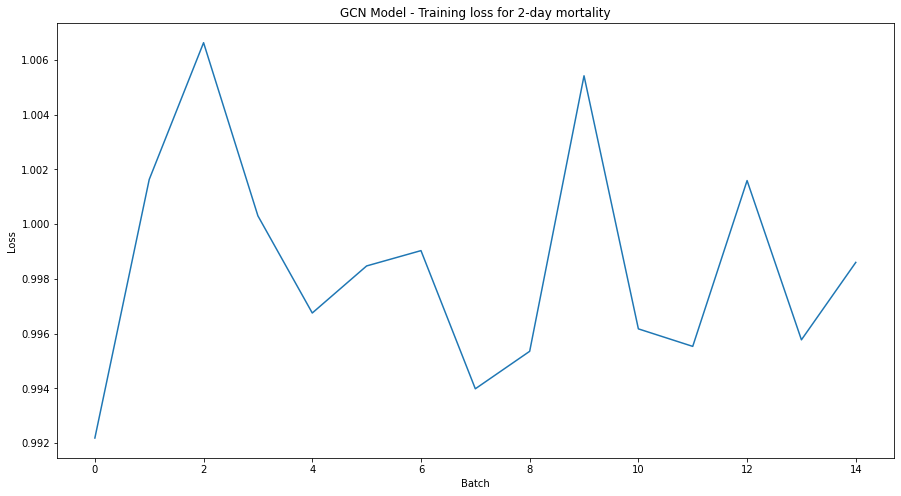

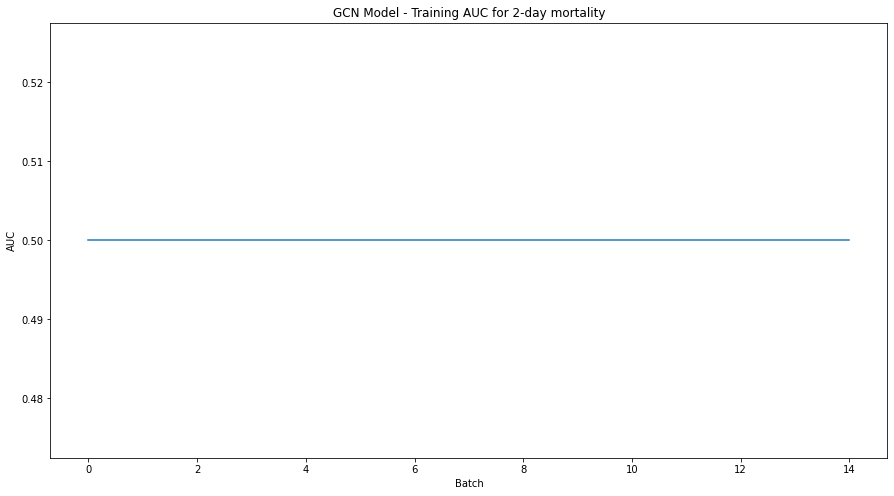

In [20]:
plt.figure(figsize=(15,8))
plt.title("GCN Model - Training loss for 2-day mortality")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(loss_p)
plt.show()

plt.figure(figsize=(15,8))
plt.title("GCN Model - Training AUC for 2-day mortality")
plt.xlabel("Batch")
plt.ylabel("AUC")
plt.plot(va_auc)
plt.show()

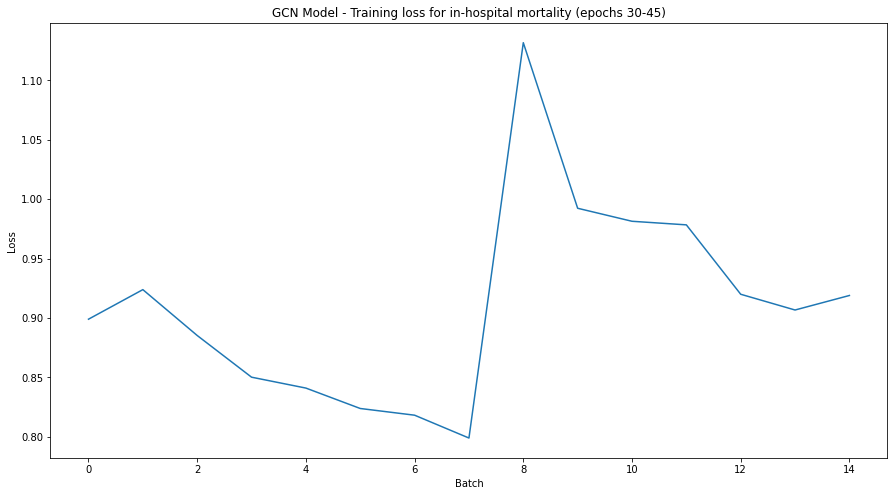

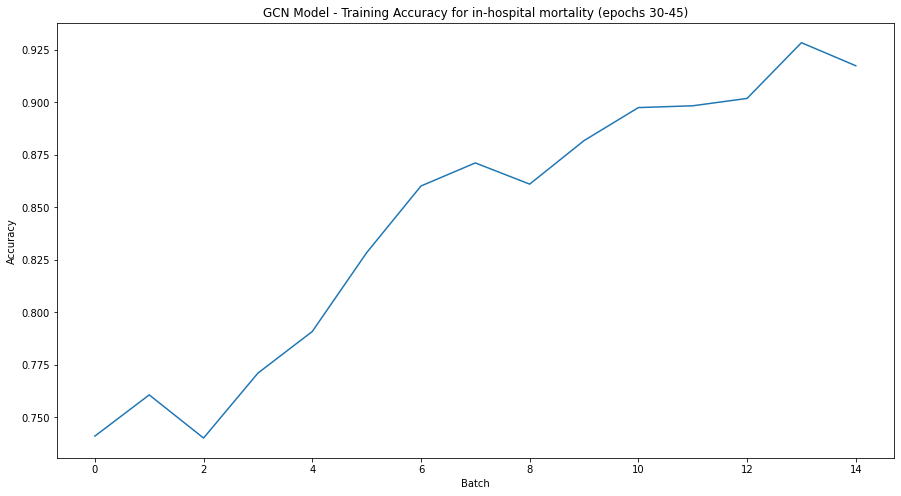

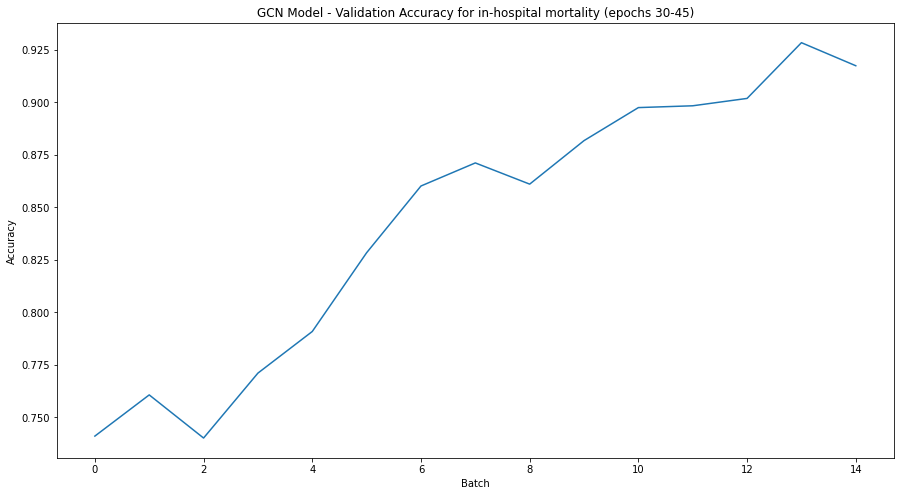

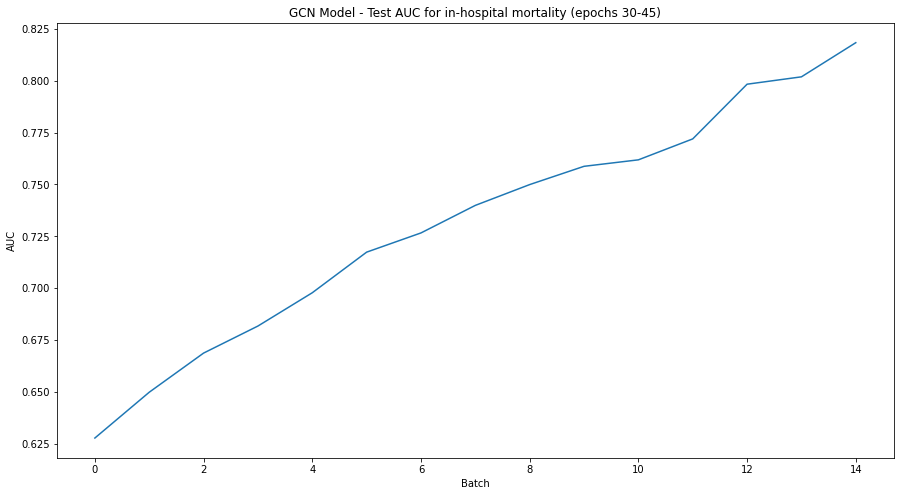

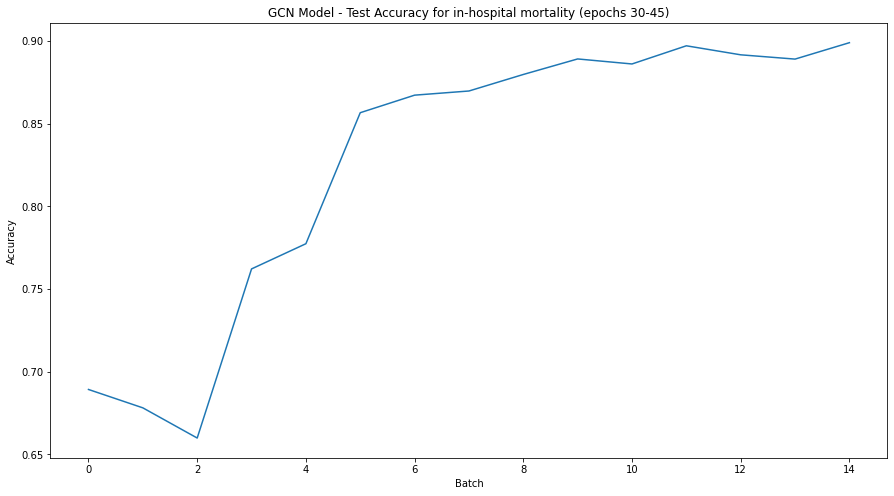

In [22]:
# plotting for in-hospital from prev-run


plt.figure(figsize=(15,8))
plt.title("GCN Model - Training loss for in-hospital mortality (epochs 30-45)")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(loss_p)
plt.show()

plt.figure(figsize=(15,8))
plt.title("GCN Model - Training Accuracy for in-hospital mortality (epochs 30-45)")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(tr_acc)
plt.show()

plt.figure(figsize=(15,8))
plt.title("GCN Model - Validation Accuracy for in-hospital mortality (epochs 30-45)")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(tr_acc)
plt.show()

plt.figure(figsize=(15,8))
plt.title("GCN Model - Test AUC for in-hospital mortality (epochs 30-45)")
plt.xlabel("Batch")
plt.ylabel("AUC")
plt.plot(te_auc)
plt.show()

plt.figure(figsize=(15,8))
plt.title("GCN Model - Test Accuracy for in-hospital mortality (epochs 30-45)")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(te_acc)
plt.show()